In [11]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import nltk

# Download NLTK resources (only needs to be run once)
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

# Load CSV file
df = pd.read_csv("../data/post_comments.csv")

# Remove empty comments and hashtags
df = df[df["text"].notna()]
df["text"] = df["text"].astype(str).apply(lambda x: re.sub(r"#\w+", "", x).strip())

# Convert timestamp column to datetime
df["createTimeISO"] = pd.to_datetime(df["createTimeISO"])

[nltk_data] Downloading package punkt to C:\Users\Surface/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Surface/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Surface/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Filtering and outliers

In [12]:
# Filter to last 6 months
from datetime import datetime
six_months_ago = pd.Timestamp(datetime.today() - pd.DateOffset(months=6), tz="UTC")
df = df[df["createTimeISO"] >= six_months_ago]

# Remove very long comments (e.g. spam or repeated text blocks)
df = df[df["text"].str.split().str.len() < 100]

# Remove comments with excessive repetition of a single word
def has_repeated_word(text, threshold=5):
    words = text.lower().split()
    word_counts = Counter(words)
    return any(count >= threshold for count in word_counts.values())

df = df[~df["text"].apply(has_repeated_word)]

Stopwords and tokenization

In [13]:
# Define standard and custom stopwords
standard_stopwords = set(stopwords.words("german")) | set(stopwords.words("english"))
custom_stopwords = {
    "i", "you", "it", "me", "this", "that", "we", "she", "he", "they", "u", "ur",
    "my", "your", "yours", "ours", "their", "its", "use", "like", "get", "need", 
    "please", "one", "would", "watch", "want", "que", "tbh", "idk", "fr", 
    "literally", "actually", "honestly", "kinda", "thing", "stuff", 
    "😭", "😂", "✨", "💀", "💅", "🥰", "😩", "😅", "🥺", "😳"
}

# Unigram-specific stopwords (standard + custom)
combined_stopwords = standard_stopwords | custom_stopwords

# Clean + tokenize for unigram analysis
def clean_tokens_unigrams(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Zäöüß]", " ", text)
    tokens = word_tokenize(text)
    return [w for w in tokens if w not in combined_stopwords and len(w) > 2]

# Clean + tokenize for n-gram analysis (no custom stopwords)
def clean_tokens_ngrams(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Zäöüß]", " ", text)
    tokens = word_tokenize(text)
    return [w for w in tokens if w not in standard_stopwords and len(w) > 2]

# Apply both tokenizations
df["unigram_tokens"] = df["text"].apply(clean_tokens_unigrams)
df["ngram_tokens"] = df["text"].apply(clean_tokens_ngrams)


Most common words

In [14]:
all_unigrams = [word for tokens in df["unigram_tokens"] for word in tokens]
common_unigrams = Counter(all_unigrams).most_common(20)

print("Top 20 unigrams:")
for word, count in common_unigrams:
    print(f"{word}: {count}")

Top 20 unigrams:
skin: 6627
love: 3629
skincare: 2648
face: 1869
good: 1813
acne: 1463
routine: 1463
products: 1439
serum: 1249
girl: 1177
care: 1144
much: 1138
beautiful: 1101
oil: 1068
toner: 1035
aku: 1020
cleanser: 1018
omg: 971
cream: 955
pretty: 944


Most common bigrams

In [15]:
all_bigrams = [bigram for tokens in df["ngram_tokens"] for bigram in ngrams(tokens, 2)]
common_bigrams = Counter([" ".join(b) for b in all_bigrams]).most_common(20)

print("\nTop 20 bigrams:")
for phrase, count in common_bigrams:
    print(f"{phrase}: {count}")


Top 20 bigrams:
skin care: 790
skincare routine: 344
cleansing oil: 330
cleaning fyp: 314
look like: 303
oily skin: 299
sensitive skin: 274
korean skincare: 264
commenting stay: 258
dry skin: 243
acne prone: 212
oil cleanser: 204
skin type: 196
skin looks: 192
wash face: 184
get rid: 182
care routine: 178
feel like: 177
looks like: 174
prone skin: 161


Most common trigrams

In [16]:
all_trigrams = [tg for tokens in df["ngram_tokens"] for tg in ngrams(tokens, 3)]
common_trigrams = Counter([" ".join(tg) for tg in all_trigrams]).most_common(20)

print("\nTop 20 Trigrams:")
for phrase, count in common_trigrams:
    print(f"{phrase}: {count}")


Top 20 Trigrams:
acne prone skin: 149
skin care routine: 140
instagram sagajewels official: 72
korean skin care: 69
would anyone watch: 67
anua cleansing oil: 62
anyone watch grwm: 59
oily acne prone: 55
izin ambil post: 55
skin looks amazing: 52
fungal acne safe: 46
good oily skin: 45
speed made famous: 44
commenting stay wonyoungism: 44
commenting stay side: 42
skin care products: 36
stay side tiktok: 36
commenting stay cleantok: 33
consumerism final boss: 31
get rid acne: 31


Word explanation

"izin ambil post" is Indonesian and means "Permission to take/use the post."

In [17]:
# Helper function to convert Counter results into DataFrame
def counter_to_df(counter, ngram_type):
    df = pd.DataFrame(counter, columns=["ngram", "count"])
    df["type"] = ngram_type
    return df

# Create Counter objects
unigram_counter = Counter(all_unigrams).most_common(20)
bigram_counter = Counter([" ".join(bg) for bg in all_bigrams]).most_common(20)
trigram_counter = Counter([" ".join(tg) for tg in all_trigrams]).most_common(20)

# Convert to DataFrames
df_unigrams = counter_to_df(unigram_counter, "unigram")
df_bigrams = counter_to_df(bigram_counter, "bigram")
df_trigrams = counter_to_df(trigram_counter, "trigram")

# Combine all into one table
df_ngrams = pd.concat([df_unigrams, df_bigrams, df_trigrams], ignore_index=True)

# Sort by count if you want (optional)
df_ngrams = df_ngrams.sort_values(by="count", ascending=False)

# Show the overview
print(df_ngrams.head(30))

               ngram  count     type
0               skin   6627  unigram
1               love   3629  unigram
2           skincare   2648  unigram
3               face   1869  unigram
4               good   1813  unigram
5               acne   1463  unigram
6            routine   1463  unigram
7           products   1439  unigram
8              serum   1249  unigram
9               girl   1177  unigram
10              care   1144  unigram
11              much   1138  unigram
12         beautiful   1101  unigram
13               oil   1068  unigram
14             toner   1035  unigram
15               aku   1020  unigram
16          cleanser   1018  unigram
17               omg    971  unigram
18             cream    955  unigram
19            pretty    944  unigram
20         skin care    790   bigram
21  skincare routine    344   bigram
22     cleansing oil    330   bigram
23      cleaning fyp    314   bigram
24         look like    303   bigram
25         oily skin    299   bigram
2

Keyword explanation (openAI)

In [18]:
#import openai
#import os
#from dotenv import load_dotenv

#load_dotenv()
#openai.api_key = os.getenv("OPENAI_API_KEY")

#from openai import OpenAI

#client = OpenAI(api_key=openai.api_key)

#keywords = [
#    "trop trop trop",
#    "sangat sangat sangat",
#    "skin care routine",
#    "wonyoungism"
#]

#for term in keywords:
#    response = client.chat.completions.create(
#        model="gpt-3.5-turbo",
#        messages=[
#            {"role": "system", "content": "You are a helpful assistant who explains slang and social media terms."},
#            {"role": "user", "content": f"Explain the term '{term}' as it appears in TikTok comments."}
#        ],
#        temperature=0.7
#    )
#    explanation = response.choices[0].message.content
#    print(f"{term}: {explanation}\n")

Trends over time

C:\Users\Surface\AppData\Local\Temp\ipykernel_22252\2635080391.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = pd.to_datetime(df["createTimeISO"]).dt.to_period("W").dt.start_time


<Figure size 1400x600 with 0 Axes>

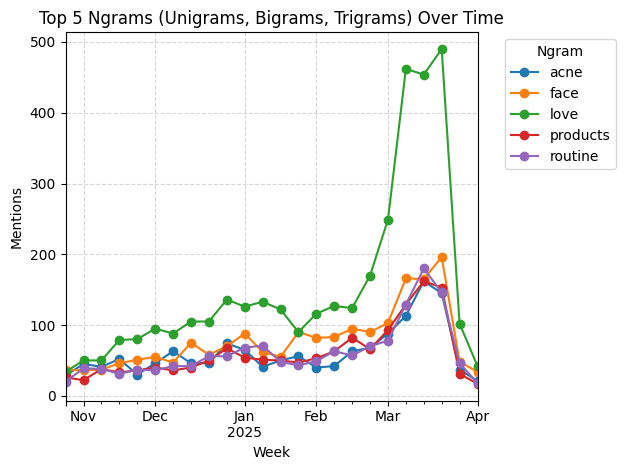

In [19]:
df["week"] = pd.to_datetime(df["createTimeISO"]).dt.to_period("W").dt.start_time

# Combine standard and custom stopwords (only for unigrams)
stop_words = set(stopwords.words("english")) | set(stopwords.words("german"))
custom_stopwords = {"use", "like", "get", "need", "please", "one", "would", "watch", "want", "que", "good", "skin", "skincare"}
combined_stopwords = stop_words | custom_stopwords

# Clean and tokenize text for unigrams
def tokenize_unigrams(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Zäöüß]", " ", text)
    tokens = word_tokenize(text)
    return [w for w in tokens if w not in combined_stopwords and len(w) > 2]

# Clean and tokenize text for ngrams
def tokenize_all(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Zäöüß]", " ", text)
    return [w for w in word_tokenize(text) if len(w) > 2]

# Apply both types of tokenization
df["unigrams"] = df["text"].apply(tokenize_unigrams)
df["tokens"] = df["text"].apply(tokenize_all)

# Generate bigrams and trigrams
df["bigrams"] = df["tokens"].apply(lambda t: [" ".join(g) for g in ngrams(t, 2)])
df["trigrams"] = df["tokens"].apply(lambda t: [" ".join(g) for g in ngrams(t, 3)])

# Combine into one long format DataFrame: week + ngram
records = []

for _, row in df.iterrows():
    for word in row["unigrams"] + row["bigrams"] + row["trigrams"]:
        records.append((row["week"], word))

df_all = pd.DataFrame(records, columns=["week", "ngram"])

# Count occurrences per week
weekly_counts = df_all.groupby(["week", "ngram"]).size().reset_index(name="count")

# Identify top 5 ngrams overall
top5 = (
    weekly_counts.groupby("ngram")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Filter only top 5 for plotting
top_weekly = weekly_counts[weekly_counts["ngram"].isin(top5)]

# Pivot to get ngrams as columns
df_trend = top_weekly.pivot(index="week", columns="ngram", values="count").fillna(0)

# Plot
plt.figure(figsize=(14, 6))
df_trend.plot(marker="o")
plt.title("Top 5 Ngrams (Unigrams, Bigrams, Trigrams) Over Time")
plt.xlabel("Week")
plt.ylabel("Mentions")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Ngram", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Most common chunks in comments

In [28]:
import spacy
from collections import Counter
from langdetect import detect
import re

# Load spaCy models
nlp_de = spacy.load("de_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

# Emoji pattern
emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)

# Normalize stopwords
combined_stopwords = {w.lower().strip() for w in combined_stopwords}

# Function to extract valid multi-word noun chunks
def extract_chunks(text, nlp_model):
    doc = nlp_model(text)
    chunks = []
    for chunk in doc.noun_chunks:
        chunk_text = chunk.text.lower().strip()
        if emoji_pattern.search(chunk_text):
            continue
        words = chunk_text.split()
        if len(words) < 2:
            continue
        if all(word in combined_stopwords for word in words):
            continue
        chunks.append(chunk_text)
    return chunks

# Collect chunks
all_chunks = []

# Analyze first 1000 comments
for text in df["text"].dropna().head(1000):
    text = text.strip()
    if not text:
        continue
    try:
        lang = detect(text)
    except:
        continue
    model = nlp_de if lang == "de" else nlp_en
    chunks = extract_chunks(text, model)
    all_chunks.extend(chunks)

# Count and display top 20
chunk_counter = Counter(all_chunks)

print("\nTop 20 Chunks:")
for chunk, count in chunk_counter.most_common(20):
    print(f"{chunk}: {count}")




Top 20 Chunks:
hair removal cream: 7
my fyp: 5
my face: 4
la roche posay: 4
moots aku plss: 4
your face: 3
fungal acne: 3
my life: 3
a mi: 3
onde comprar: 3
this brand: 3
a good boy: 3
good boy: 3
my car: 2
this type: 2
friendship attack: 2
magic shaving powder: 2
your winter shade: 2
a lot: 2
dark circles: 2
